Add Starting Pitching to Model

    In the last notebook we augmented our dataframe to include various features based on the starting pitcher's performance
    Now we will add these features in to see how much improvement we get to our model.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgbm
import structureboost as stb
import ml_insights as mli
from structureboost import log_loss
pd.set_option('display.max_columns',1000)
pd.set_option('display.max_rows',1000)

In [2]:
df = pd.read_csv('df_bp5.csv', low_memory=False)

BEGIN MODELING

In [3]:
df = df[df.run_diff!=0]
df_train = df[(df.season>1901) & (df.season<=2000)]
df_valid = df[(df.season>=2001) & (df.season<=2020)]
df_test = df[df.season>=2021]

In [4]:
hv_mean = df_train.home_victory.mean()

FIRST -- Just add in ERA and WHIP over last 35 games (in addition to first model params)

In [5]:
features = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v', 
            'Strt_ERA_35_h','Strt_ERA_35_v',
            'Strt_WHIP_35_h','Strt_WHIP_35_v', 
]
target = 'home_victory'

In [6]:
X_train = df_train.loc[:,features]
X_valid = df_valid.loc[:,features]
X_test = df_test.loc[:,features]

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()

In [7]:
X_train.shape, X_valid.shape, X_test.shape

((80143, 8), (47044, 8), (4852, 8))

In [8]:
lgbm1 = lgbm.LGBMClassifier(n_estimators=1000, learning_rate=.02, max_depth=2)
lgbm1.fit(X_train, y_train, eval_set=(X_valid, y_valid), eval_metric='logloss', 
          callbacks=[lgbm.early_stopping(stopping_rounds=50), lgbm.log_evaluation(10)])

Training until validation scores don't improve for 50 rounds
[10]	valid_0's binary_logloss: 0.68895
[20]	valid_0's binary_logloss: 0.688183
[30]	valid_0's binary_logloss: 0.687503
[40]	valid_0's binary_logloss: 0.686913
[50]	valid_0's binary_logloss: 0.686468
[60]	valid_0's binary_logloss: 0.685936
[70]	valid_0's binary_logloss: 0.685494
[80]	valid_0's binary_logloss: 0.685126
[90]	valid_0's binary_logloss: 0.684779
[100]	valid_0's binary_logloss: 0.68445
[110]	valid_0's binary_logloss: 0.684183
[120]	valid_0's binary_logloss: 0.683904
[130]	valid_0's binary_logloss: 0.683689
[140]	valid_0's binary_logloss: 0.683448
[150]	valid_0's binary_logloss: 0.683243
[160]	valid_0's binary_logloss: 0.683063
[170]	valid_0's binary_logloss: 0.682893
[180]	valid_0's binary_logloss: 0.682728
[190]	valid_0's binary_logloss: 0.682576
[200]	valid_0's binary_logloss: 0.682424
[210]	valid_0's binary_logloss: 0.682286
[220]	valid_0's binary_logloss: 0.682176
[230]	valid_0's binary_logloss: 0.68209
[240]	va

LGBMClassifier(learning_rate=0.02, max_depth=2, n_estimators=1000)

In [9]:
preds_lgbm = lgbm1.predict_proba(X_test)[:,1]

In [10]:
# previous model gave 0.6905369911423601
log_loss(y_test, preds_lgbm), log_loss(y_test, hv_mean*np.ones(len(y_test)))

(0.6748193262779676, 0.690490020243992)

In [11]:
log_loss(y_test,df_test.implied_prob_h_mid)

0.6675629431340582

In [12]:
# naive-LV, naive-simp_mod, naive-current_mod

np.round([0.6905 - 0.6676, 0.6905 - 0.6845, 0.6905 - 0.6748], decimals=4)

array([0.0229, 0.006 , 0.0157])

In [13]:
rd = mli.get_range_dict(X_train)
plot_pts = X_test.sample(3, random_state=42)

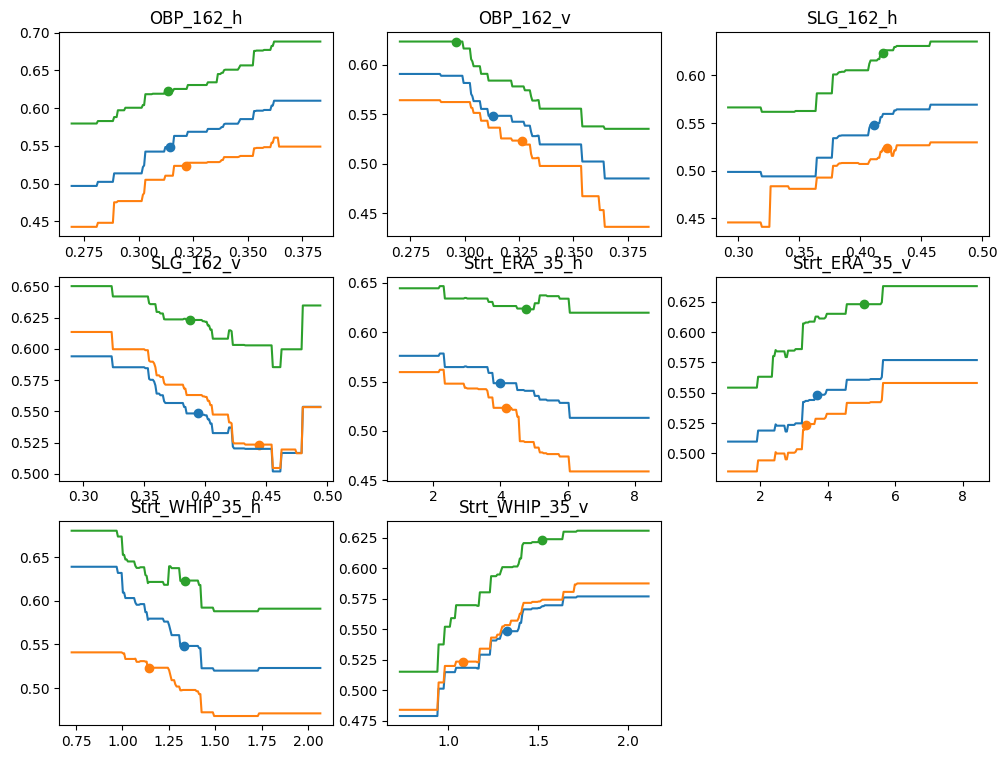

In [14]:
mli.ice_plot(lgbm1, plot_pts, X_test.columns, mli.get_range_dict(X_train), plots_per_row=3)

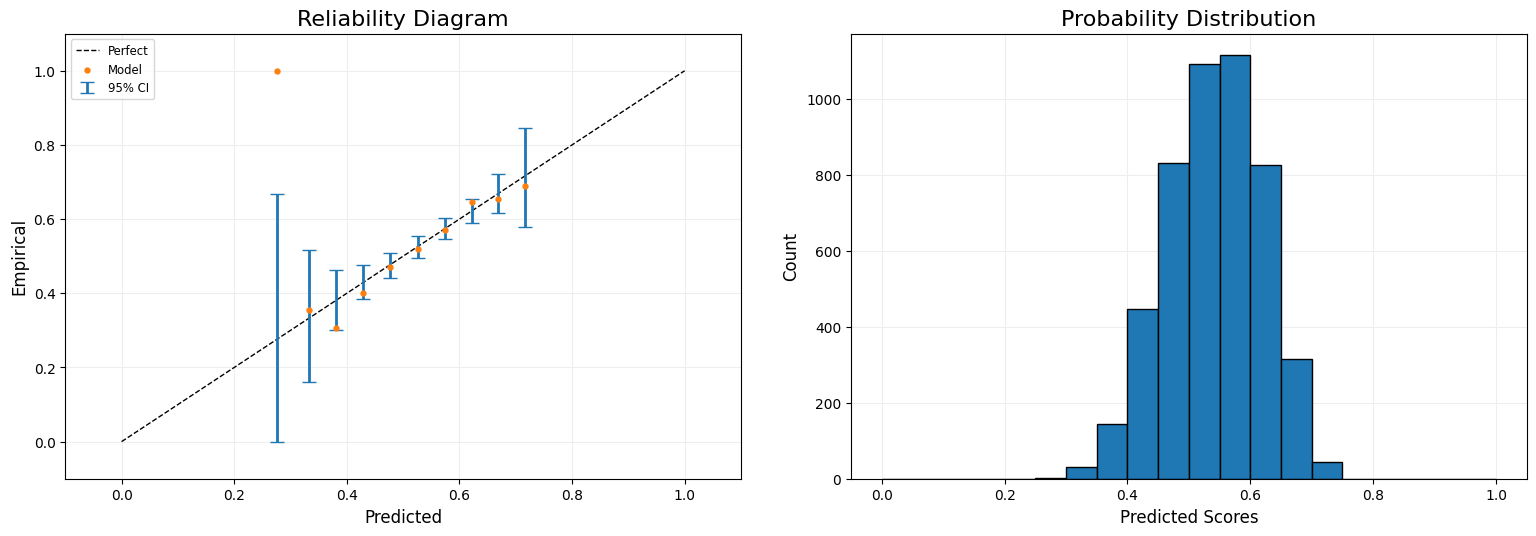

In [15]:
plt.figure(figsize=(16,6))
mli.plot_reliability_diagram(y_test, preds_lgbm, show_histogram=True);

In [16]:
sv_lgbm = lgbm1.predict(X_test, pred_contrib=True)
sv_lgbm = pd.DataFrame(sv_lgbm)
sv_lgbm.columns = list(X_test.columns)+['Intercept']

In [17]:
# This shows for each game, how the different features affected 

sv_lgbm.head(5).round(3)

,OBP_162_h,OBP_162_v,SLG_162_h,SLG_162_v,Strt_ERA_35_h,Strt_ERA_35_v,Strt_WHIP_35_h,Strt_WHIP_35_v,Intercept
0,-0.060,0.080,0.114,-0.020,0.038,0.025,0.199,0.072,0.156
1,-0.057,0.022,0.116,-0.009,0.006,-0.094,0.091,-0.187,0.156
2,0.014,0.015,0.094,-0.131,-0.078,-0.098,0.088,-0.164,0.156
3,-0.164,0.032,0.015,-0.096,0.037,-0.081,0.033,-0.117,0.156
4,-0.031,0.013,0.060,-0.121,0.030,-0.000,0.132,-0.348,0.156


In [18]:
df_test.pitcher_start_name_v.iloc[2]

'Clayton Kershaw'

In [19]:
sv_lgbm.abs().mean().sort_values(ascending=False)

Intercept         0.155845
Strt_WHIP_35_h    0.092519
Strt_WHIP_35_v    0.072990
SLG_162_h         0.069840
OBP_162_h         0.068175
OBP_162_v         0.065902
SLG_162_v         0.060655
Strt_ERA_35_v     0.053727
Strt_ERA_35_h     0.044703
dtype: float64

Let's add in a few more pitching features...

In [20]:
# Add in SO% and "Modified Slugging Against"

features = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v', 
            'Strt_ERA_35_h','Strt_ERA_35_v',
            'Strt_WHIP_35_h','Strt_WHIP_35_v',
            'Strt_SO_perc_35_h', 'Strt_SO_perc_35_v',
            'Strt_TB_BB_perc_35_h', 'Strt_TB_BB_perc_35_v',
            'Strt_H_BB_perc_35_h', 'Strt_H_BB_perc_35_v',
]
target = 'home_victory'

In [21]:
X_train = df_train.loc[:,features]
X_valid = df_valid.loc[:,features]
X_test = df_test.loc[:,features]

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()

In [22]:
X_train.shape, X_valid.shape, X_test.shape

((80143, 14), (47044, 14), (4852, 14))

In [23]:
lgbm1 = lgbm.LGBMClassifier(n_estimators=1000, learning_rate=.02, max_depth=2)
lgbm1.fit(X_train, y_train, eval_set=(X_valid, y_valid), eval_metric='logloss', 
          callbacks=[lgbm.early_stopping(stopping_rounds=50), lgbm.log_evaluation(10)])

Training until validation scores don't improve for 50 rounds
[10]	valid_0's binary_logloss: 0.688927
[20]	valid_0's binary_logloss: 0.688134
[30]	valid_0's binary_logloss: 0.687461
[40]	valid_0's binary_logloss: 0.686806
[50]	valid_0's binary_logloss: 0.686294
[60]	valid_0's binary_logloss: 0.685752
[70]	valid_0's binary_logloss: 0.685332
[80]	valid_0's binary_logloss: 0.684943
[90]	valid_0's binary_logloss: 0.684568
[100]	valid_0's binary_logloss: 0.684163
[110]	valid_0's binary_logloss: 0.683863
[120]	valid_0's binary_logloss: 0.683563
[130]	valid_0's binary_logloss: 0.68333
[140]	valid_0's binary_logloss: 0.683091
[150]	valid_0's binary_logloss: 0.682865
[160]	valid_0's binary_logloss: 0.68265
[170]	valid_0's binary_logloss: 0.682477
[180]	valid_0's binary_logloss: 0.682285
[190]	valid_0's binary_logloss: 0.682139
[200]	valid_0's binary_logloss: 0.681981
[210]	valid_0's binary_logloss: 0.681849
[220]	valid_0's binary_logloss: 0.681695
[230]	valid_0's binary_logloss: 0.681575
[240]	v

LGBMClassifier(learning_rate=0.02, max_depth=2, n_estimators=1000)

In [24]:
preds_lgbm = lgbm1.predict_proba(X_test)[:,1]

In [25]:
log_loss(y_test, preds_lgbm), log_loss(y_test, hv_mean*np.ones(len(y_test)))

(0.6751094747686894, 0.690490020243992)

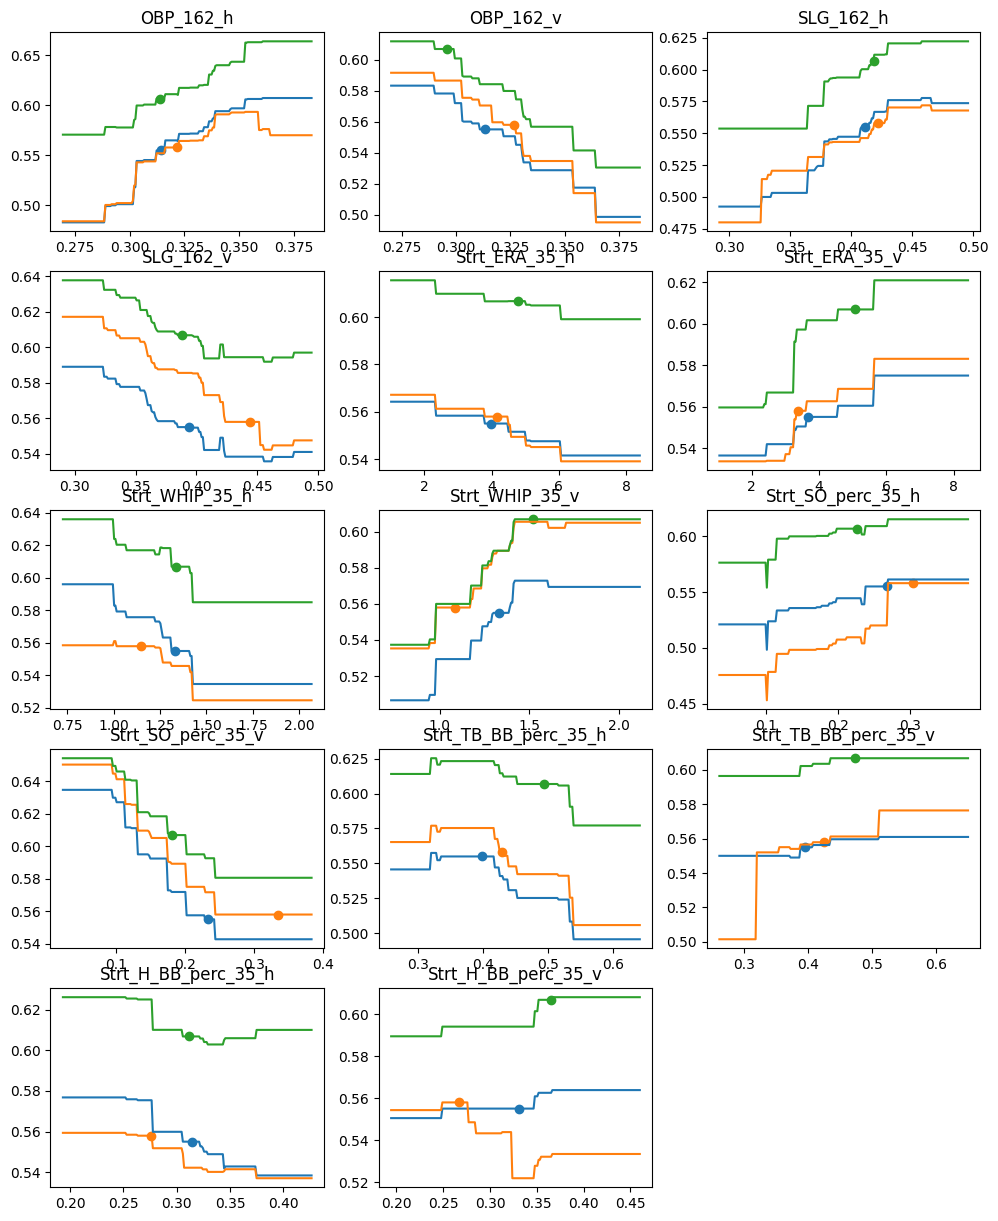

In [26]:
rd = mli.get_range_dict(X_train)
plot_pts = X_test.sample(3, random_state=42)

mli.ice_plot(lgbm1, plot_pts, X_test.columns, mli.get_range_dict(X_train), plots_per_row=3)

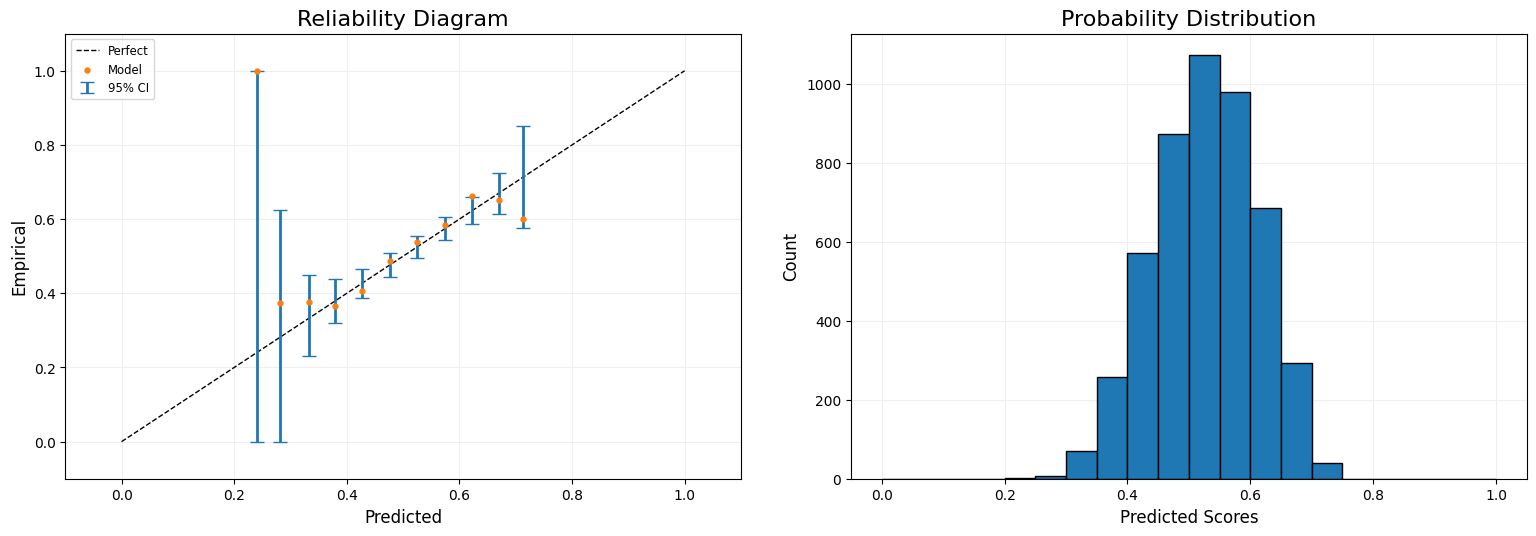

In [27]:
plt.figure(figsize=(16,6))
mli.plot_reliability_diagram(y_test, preds_lgbm, show_histogram=True);

In [28]:
sv_lgbm = lgbm1.predict(X_test, pred_contrib=True)
sv_lgbm = pd.DataFrame(sv_lgbm)
sv_lgbm.columns = list(X_test.columns)+['Intercept']

In [29]:
sv_lgbm.abs().mean().sort_values(ascending=False)

Intercept               0.155795
Strt_SO_perc_35_v       0.125909
Strt_SO_perc_35_h       0.079190
OBP_162_h               0.073312
SLG_162_h               0.065026
OBP_162_v               0.057265
Strt_WHIP_35_h          0.054422
Strt_WHIP_35_v          0.054357
SLG_162_v               0.050621
Strt_ERA_35_v           0.042379
Strt_TB_BB_perc_35_h    0.040143
Strt_H_BB_perc_35_h     0.031858
Strt_ERA_35_h           0.013168
Strt_H_BB_perc_35_v     0.013012
Strt_TB_BB_perc_35_v    0.012422
dtype: float64

In [30]:
## Let's add in the 10 game lookback features
features = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v', 
            'Strt_ERA_35_h','Strt_ERA_35_v',
            'Strt_WHIP_35_h','Strt_WHIP_35_v',
            'Strt_SO_perc_35_h', 'Strt_SO_perc_35_v',
            'Strt_TB_BB_perc_35_h', 'Strt_TB_BB_perc_35_v',
            'Strt_ERA_10_h','Strt_ERA_10_v',
            'Strt_WHIP_10_h','Strt_WHIP_10_v',
            'Strt_SO_perc_10_h', 'Strt_SO_perc_10_v',
            'Strt_TB_BB_perc_10_h', 'Strt_TB_BB_perc_10_v',
]
target = 'home_victory'

In [31]:
X_train = df_train.loc[:,features]
X_valid = df_valid.loc[:,features]
X_test = df_test.loc[:,features]

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()


In [32]:
X_train.shape, X_valid.shape, X_test.shape

((80143, 20), (47044, 20), (4852, 20))

In [33]:
lgbm1 = lgbm.LGBMClassifier(n_estimators=1000, learning_rate=.02, max_depth=2)
lgbm1.fit(X_train, y_train, eval_set=(X_valid, y_valid), eval_metric='logloss', 
          callbacks=[lgbm.early_stopping(stopping_rounds=50), lgbm.log_evaluation(10)])

Training until validation scores don't improve for 50 rounds
[10]	valid_0's binary_logloss: 0.68886
[20]	valid_0's binary_logloss: 0.688128
[30]	valid_0's binary_logloss: 0.687452
[40]	valid_0's binary_logloss: 0.686887
[50]	valid_0's binary_logloss: 0.686373
[60]	valid_0's binary_logloss: 0.685861
[70]	valid_0's binary_logloss: 0.6854
[80]	valid_0's binary_logloss: 0.684988
[90]	valid_0's binary_logloss: 0.684644
[100]	valid_0's binary_logloss: 0.684305
[110]	valid_0's binary_logloss: 0.684016
[120]	valid_0's binary_logloss: 0.683727
[130]	valid_0's binary_logloss: 0.683442
[140]	valid_0's binary_logloss: 0.683191
[150]	valid_0's binary_logloss: 0.682961
[160]	valid_0's binary_logloss: 0.682785
[170]	valid_0's binary_logloss: 0.682576
[180]	valid_0's binary_logloss: 0.682384
[190]	valid_0's binary_logloss: 0.682193
[200]	valid_0's binary_logloss: 0.682042
[210]	valid_0's binary_logloss: 0.681901
[220]	valid_0's binary_logloss: 0.681756
[230]	valid_0's binary_logloss: 0.681602
[240]	va

LGBMClassifier(learning_rate=0.02, max_depth=2, n_estimators=1000)

In [34]:
preds_lgbm = lgbm1.predict_proba(X_test)[:,1]

In [35]:
log_loss(y_test, preds_lgbm), log_loss(y_test, hv_mean*np.ones(len(y_test)))

(0.6747448314790544, 0.690490020243992)

In [36]:
rd = mli.get_range_dict(X_train)
plot_pts = X_test.sample(3, random_state=42)

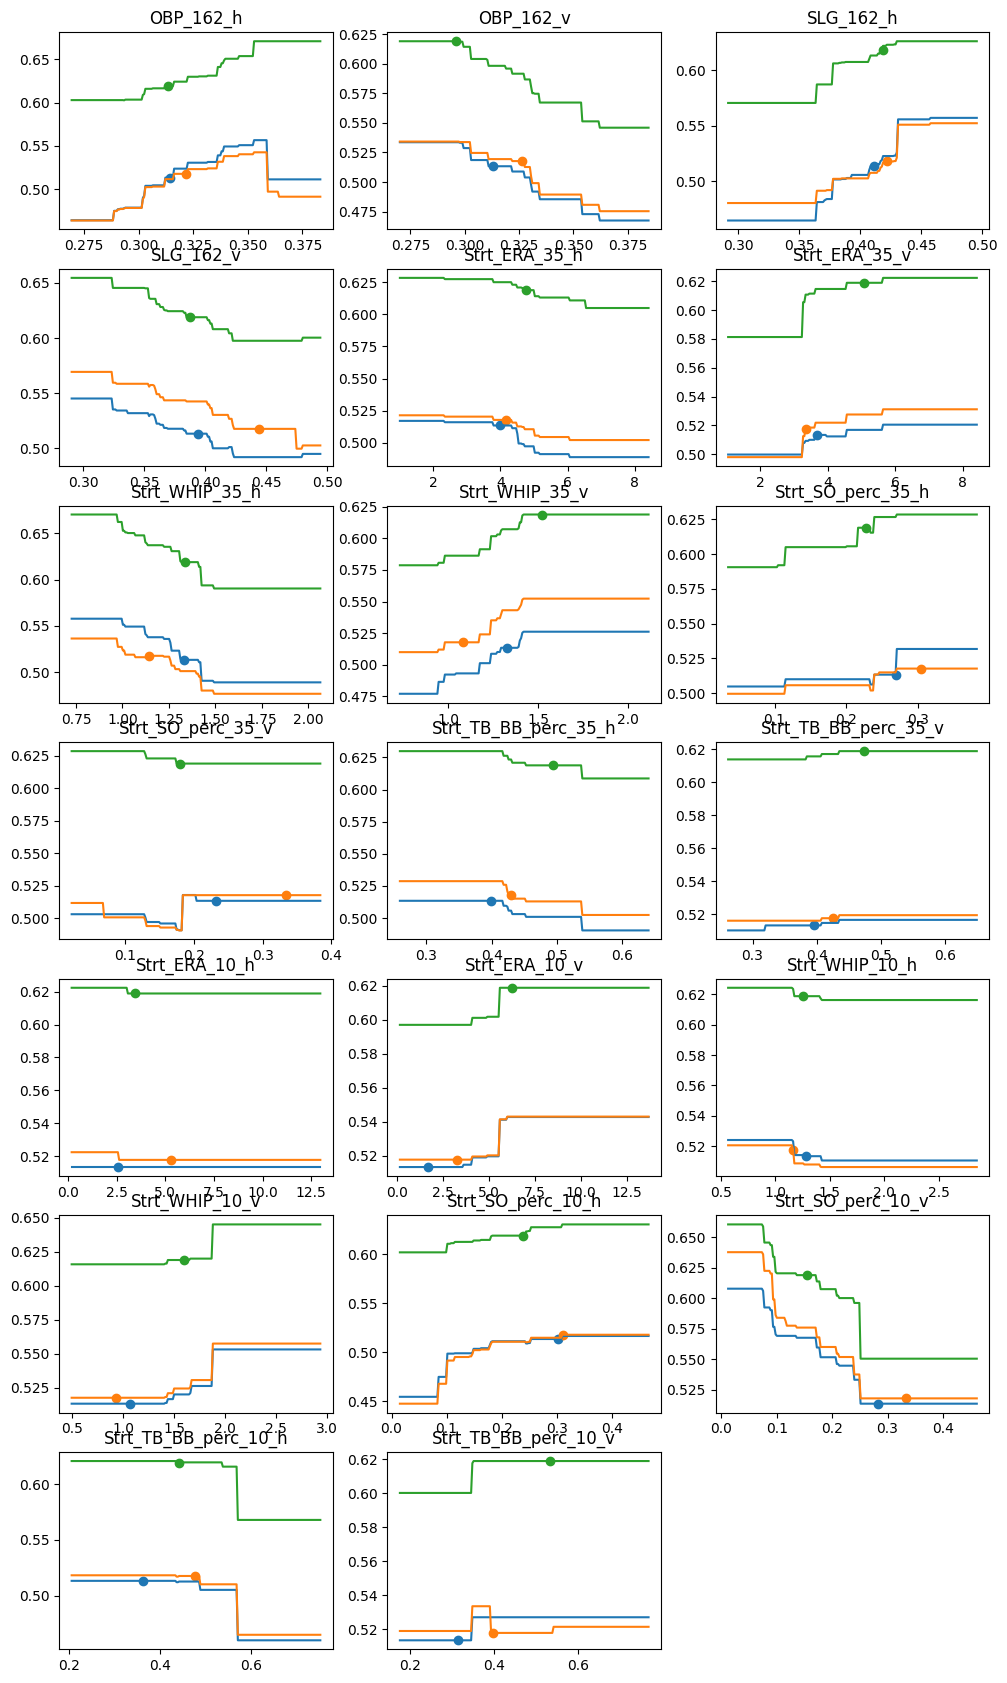

In [37]:
mli.ice_plot(lgbm1, plot_pts, X_test.columns, mli.get_range_dict(X_train), plots_per_row=3)

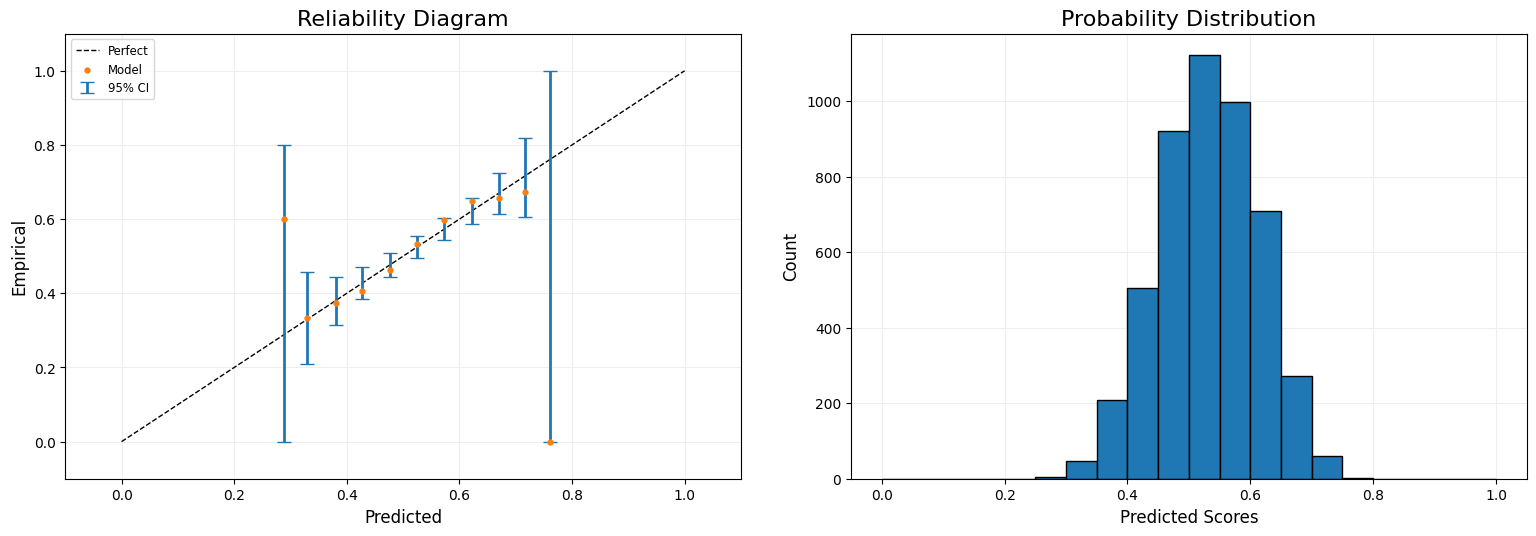

In [38]:
plt.figure(figsize=(16,6))
mli.plot_reliability_diagram(y_test, preds_lgbm, show_histogram=True);

In [39]:
sv_lgbm = lgbm1.predict(X_test, pred_contrib=True)
sv_lgbm = pd.DataFrame(sv_lgbm)
sv_lgbm.columns = list(X_test.columns)+['Intercept']

In [40]:
sv_lgbm.abs().mean().sort_values(ascending=False)

Intercept               0.155722
Strt_SO_perc_10_v       0.094790
Strt_WHIP_35_h          0.069492
OBP_162_h               0.063827
Strt_SO_perc_10_h       0.062880
SLG_162_h               0.061864
OBP_162_v               0.051400
SLG_162_v               0.050876
Strt_WHIP_35_v          0.048508
Strt_ERA_35_v           0.036368
Strt_TB_BB_perc_35_h    0.028271
Strt_SO_perc_35_h       0.024838
Strt_SO_perc_35_v       0.024337
Strt_ERA_35_h           0.015188
Strt_ERA_10_v           0.014900
Strt_WHIP_10_h          0.014431
Strt_TB_BB_perc_10_v    0.009321
Strt_WHIP_10_v          0.006804
Strt_TB_BB_perc_35_v    0.006437
Strt_TB_BB_perc_10_h    0.006191
Strt_ERA_10_h           0.001575
dtype: float64

In [41]:
# Choose the best window size for each metric, drop ERA
features = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v', 
            'Strt_WHIP_35_h','Strt_WHIP_35_v',
            'Strt_TB_BB_perc_35_h', 'Strt_TB_BB_perc_35_v',
            'Strt_SO_perc_10_h', 'Strt_SO_perc_10_v',
            
]
target = 'home_victory'

In [42]:
X_train = df_train.loc[:,features]
X_valid = df_valid.loc[:,features]
X_test = df_test.loc[:,features]

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()

In [43]:
X_train.shape, X_valid.shape, X_test.shape

((80143, 10), (47044, 10), (4852, 10))

In [44]:
lgbm1 = lgbm.LGBMClassifier(n_estimators=1000, learning_rate=.02, max_depth=2)
lgbm1.fit(X_train, y_train, eval_set=(X_valid, y_valid), eval_metric='logloss', 
          callbacks=[lgbm.early_stopping(stopping_rounds=50), lgbm.log_evaluation(10)])

Training until validation scores don't improve for 50 rounds
[10]	valid_0's binary_logloss: 0.688887
[20]	valid_0's binary_logloss: 0.688068
[30]	valid_0's binary_logloss: 0.687425
[40]	valid_0's binary_logloss: 0.686827
[50]	valid_0's binary_logloss: 0.686325
[60]	valid_0's binary_logloss: 0.685838
[70]	valid_0's binary_logloss: 0.685376
[80]	valid_0's binary_logloss: 0.68498
[90]	valid_0's binary_logloss: 0.68463
[100]	valid_0's binary_logloss: 0.684268
[110]	valid_0's binary_logloss: 0.68395
[120]	valid_0's binary_logloss: 0.683681
[130]	valid_0's binary_logloss: 0.683424
[140]	valid_0's binary_logloss: 0.683186
[150]	valid_0's binary_logloss: 0.682983
[160]	valid_0's binary_logloss: 0.682773
[170]	valid_0's binary_logloss: 0.682595
[180]	valid_0's binary_logloss: 0.682421
[190]	valid_0's binary_logloss: 0.682263
[200]	valid_0's binary_logloss: 0.682061
[210]	valid_0's binary_logloss: 0.68188
[220]	valid_0's binary_logloss: 0.681739
[230]	valid_0's binary_logloss: 0.681597
[240]	val

LGBMClassifier(learning_rate=0.02, max_depth=2, n_estimators=1000)

In [45]:
preds_lgbm = lgbm1.predict_proba(X_test)[:,1]

In [46]:
# now about 4 bps worse than previous model..
log_loss(y_test, preds_lgbm), log_loss(y_test, hv_mean*np.ones(len(y_test)))

(0.6751157305303654, 0.690490020243992)

In [47]:
log_loss(y_test,df_test.implied_prob_h_mid)

0.6675629431340582

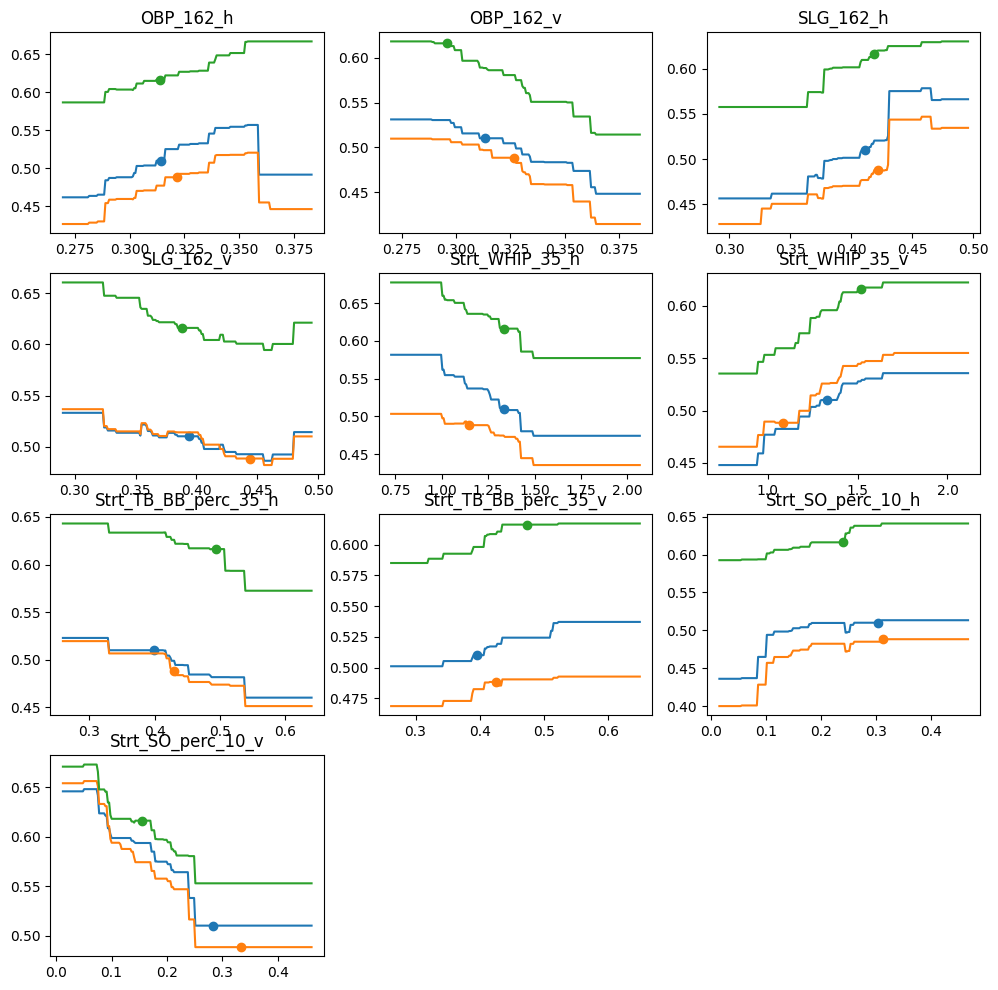

In [48]:
rd = mli.get_range_dict(X_train)
plot_pts = X_test.sample(3, random_state=42)
mli.ice_plot(lgbm1, plot_pts, X_test.columns, mli.get_range_dict(X_train), plots_per_row=3)

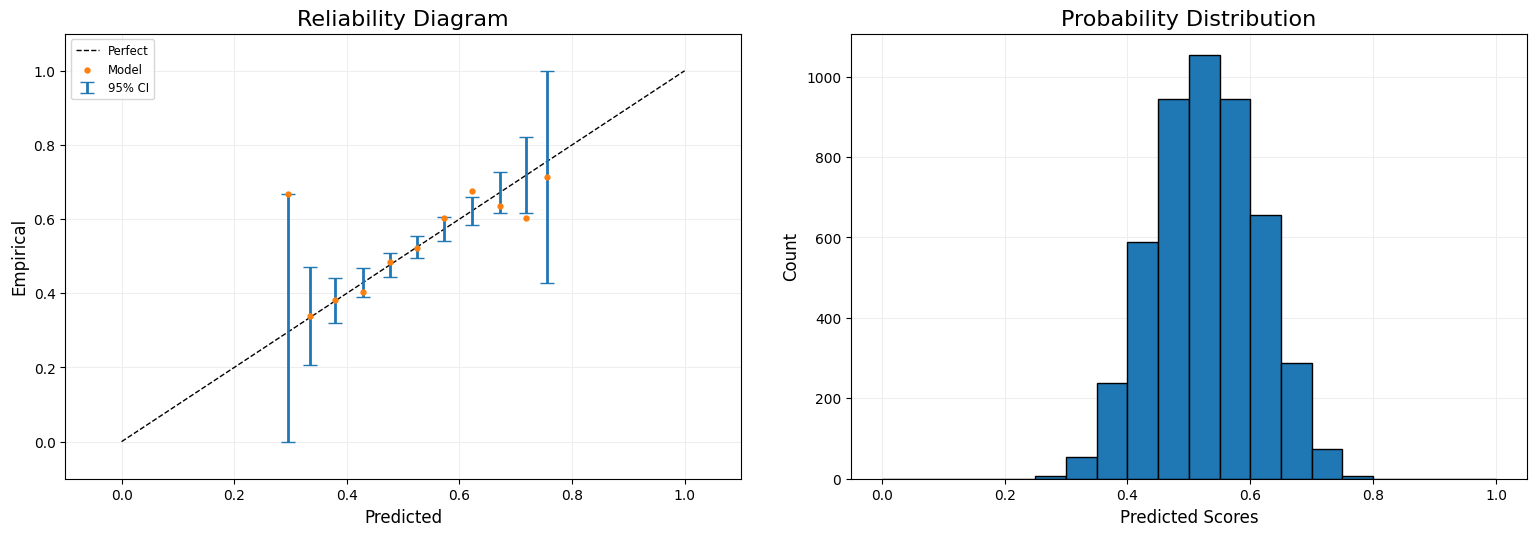

In [49]:
plt.figure(figsize=(16,6))
mli.plot_reliability_diagram(y_test, preds_lgbm, show_histogram=True);

In [50]:
sv_lgbm = lgbm1.predict(X_test, pred_contrib=True)
sv_lgbm = pd.DataFrame(sv_lgbm)
sv_lgbm.columns = list(X_test.columns)+['Intercept']

In [51]:
sv_lgbm.abs().mean().sort_values(ascending=False)

Intercept               0.156018
Strt_SO_perc_10_v       0.134203
Strt_SO_perc_10_h       0.094904
Strt_WHIP_35_h          0.084779
Strt_WHIP_35_v          0.075876
SLG_162_h               0.069642
OBP_162_h               0.066945
OBP_162_v               0.058553
SLG_162_v               0.052705
Strt_TB_BB_perc_35_h    0.044931
Strt_TB_BB_perc_35_v    0.035032
dtype: float64

How much do these differences in log loss really mean?

When model A does a few bps better than model B in log loss, how should we think about that?

Is it a meaningful improvement?
How do we know it is not just "luck of the draw" of the test set
We'll run some quick simulations to build our intuition about this.

In [52]:
# Simulate a test set (with given "true" probabilities) and compare two models, 
def ll_dist(probvec_true, probvec_mod1, probvec_mod2, num_trials):
    llvec_mod1 = np.zeros(num_trials)
    llvec_mod2 = np.zeros(num_trials)
    for i in range(num_trials):
        sim_outcome = np.random.binomial(n=1, p=probvec_true)
        llvec_mod1[i] = log_loss(sim_outcome, probvec_mod1)
        llvec_mod2[i] = log_loss(sim_outcome, probvec_mod2)
    return(llvec_mod1 - llvec_mod2)

In [53]:
pv_true = df_test.implied_prob_h_mid
pv_mod1 = pv_true + np.random.uniform(-.02, .02, len(pv_true))
pv_mod2 = pv_true + np.random.uniform(-.04, .04, len(pv_true))

disc = ll_dist(pv_true, pv_mod1, pv_mod2, 10000)

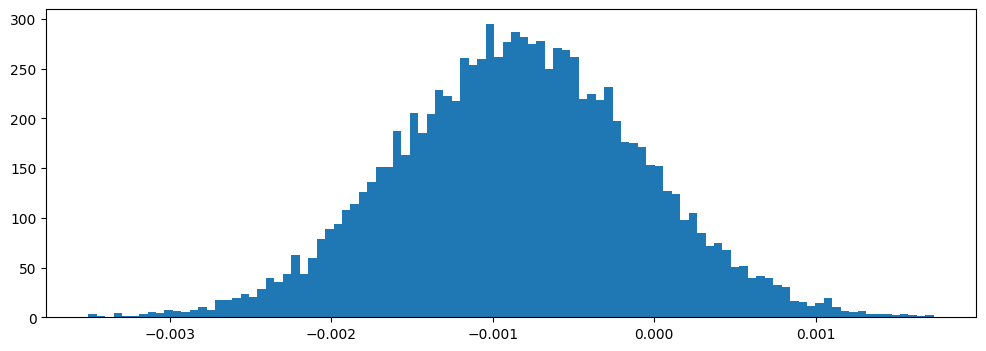

In [54]:
plt.figure(figsize=(12,4))
plt.hist(disc, bins=100);

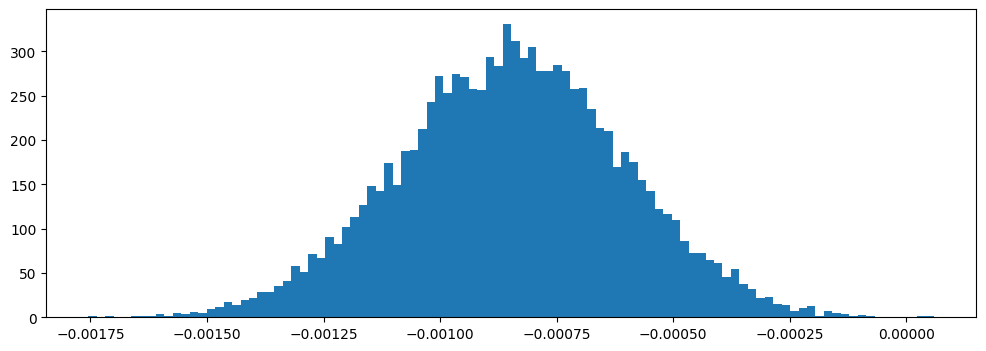

In [55]:
pv_true = np.repeat(df_test.implied_prob_h_mid,10)
pv_mod1 = pv_true + np.random.uniform(-.02, .02, len(pv_true))
pv_mod2 = pv_true + np.random.uniform(-.04, .04, len(pv_true))

disc = ll_dist(pv_true, pv_mod1, pv_mod2, 10000)
plt.figure(figsize=(12,4))
plt.hist(disc, bins=100);

In [56]:
pv_true = df_test.implied_prob_h_mid
pv_mod1 = pv_true + np.random.uniform(-.02, .02, len(pv_true))
pv_mod2 = pv_true + np.random.uniform(-.10, .10, len(pv_true))

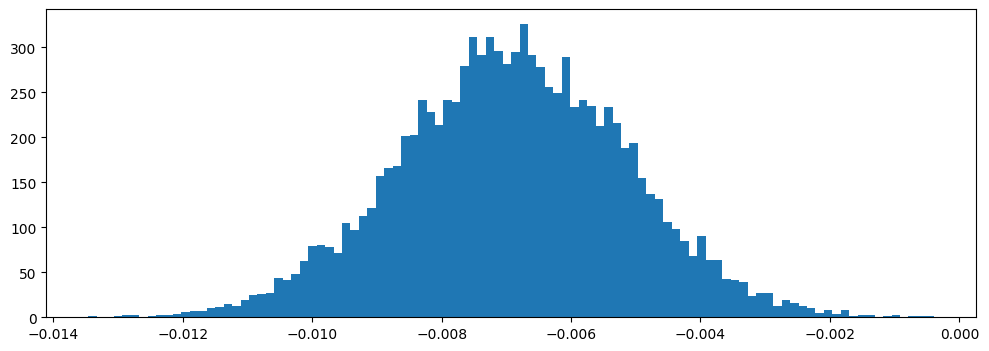

In [57]:

disc = ll_dist(pv_true, pv_mod1, pv_mod2, 10000)
plt.figure(figsize=(12,4))
plt.hist(disc, bins=100);

Conclusions

    - Could be that 5-10 bps improvement is meaningful!
    - Variation due to test set size is considerable
    - Not a simple matter to increase test set size in this problem
    - For now, still need to improve beyond minor optimizations


Potential Next Steps??

    - Have nothing about the quality of the bullpen
    - Bullpen is more meaningful in recent years, as starting pitchers work fewer innings
    - Could cause an issue with "model drift" (something to explore later on)
    - We don't account for the specific hitting lineup (would need individual batter data)
    - We have nothing about fielding
    - Several additional sources of model drift
    - Rule changes about infield positioning
    - Pitching clock
    - NL now has a DH